# Proyecto 03 - Sistema de recomendación de videojuegos en Steam

El objetivo del proyecto es crear un sistema de recomendación de videojuegos para la plataforma Steam, esto a partir de las reviews de los usuarios y los datos de los videojuegos.

## 0. Librerias y conformación de los datasets

In [2]:
# Importamos la librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para optimizar el uso de la RAM
import gzip
import gc #garbage collector

# Librerías para la predicción - Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV


from collections import defaultdict
from surprise import Dataset
import random
from icecream import ic

In [3]:
# Definimos una función para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
# Importar los datos de las caracteristicas de los juegos

# Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000
for i, l in enumerate(parse(r'datos/steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break

In [5]:
# Importar los datos de las reviews

# Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos/steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break

In [6]:
# Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)

In [7]:
# Revisamos el dataset de reviews
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Notamos que el dataset contiene las siguientes columnas:

* username: Nombre del usuario que realiza la review
* hours: Número de horas que pasó jugando el juego hasta el momento de la review
* products: Cantidad de productos adquiridos por el usuario
* product_id: Código del producto al que le corresponde la review
* page_order: 
* date: Fecha de la reseña
* text: Texto de la reseña
* early_acces: Indica si el usuario recibió acceso temprano al juego o no
* page: página donde se encuentra la reseña
* found_funny: Cantidad de personas que marcaron la reseña como "divertida"
* compensation: Si el juego fue recibido de forma gratuita o no
* user_id: Código de identificación para el usuario

Vamos a limpiar un poco el dataset quitando las columnas que no nos interesan

In [8]:
df_rev = df_rev.drop(columns=['page_order','early_access','page','found_funny','compensation', 'date', 'text'])

También eliminamos aquellas isntancias que se encuentran repetidas en el dataset

In [9]:
# Eliminamos filas duplicadas
df_rev = df_rev.drop_duplicates()

A continuación, vamos a agregar datos de algunos usuarios externos a los que se encuentran en el dataset con el fin de verificar el sistema de recomendaciones al finalizar la implementación

In [10]:
## diccionario de usuario
dict_user = ['Andres Velasquez',{
                            236850:200,
                            252950:100,
                            281990:200,
                            202970:300,
                            254300:400,
                            8930:50,
                            620:100,
                            113200:100
                                }
            ]
dict_user2 = [
    'Mauricio Perea', {
        236850:800,
        394360:213,
        8930:118
#  hearts of iron 394360
# 8930    civilization
    }
]
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
99993,apotterx1,1.3,11.0,461560,NaN
99994,Gargoylenbe ✌,0.6,259.0,461560,NaN
99995,edvineriS,0.9,34.0,461560,76561198215396451
99999,MeltDown,1.3,223.0,233270,NaN


In [11]:
### esta funcion mete los juegos al dataset
dfrev2 = df_rev.copy()

username = dict_user[0]
for id_game, hours in dict_user[1].items():
    dic_tool = {
        'username': username,
        'hours': hours,
        'product_id': str(id_game),
        'products': 8,
        'user_id': 1
    }
    dfrev2 = dfrev2.append(dic_tool, ignore_index=True)
    
username2 = dict_user2[0]
for id_game2, hours2 in dict_user2[1].items():
    dic_tool2 = {
        'username': username2,
        'hours': hours2,
        'product_id': str(id_game2),
        'products': 8,
        'user_id': 2
    }
    dfrev2 = dfrev2.append(dic_tool2, ignore_index=True)

dfrev2.tail(20)
df_rev = dfrev2.copy()
df_rev.tail(15)

,username,hours,products,product_id,user_id
96917,Gargoylenbe ✌,0.6,259.0,461560,NaN
96918,edvineriS,0.9,34.0,461560,76561198215396451
96919,MeltDown,1.3,223.0,233270,NaN
96920,Generalis,7.9,255.0,233270,NaN
96921,Andres Velasquez,200.0,8.0,236850,1
96922,Andres Velasquez,100.0,8.0,252950,1
96923,Andres Velasquez,200.0,8.0,281990,1
96924,Andres Velasquez,300.0,8.0,202970,1
96925,Andres Velasquez,400.0,8.0,254300,1
96926,Andres Velasquez,50.0,8.0,8930,1


In [12]:
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
96927,Andres Velasquez,100.0,8.0,620,1
96928,Andres Velasquez,100.0,8.0,113200,1
96929,Mauricio Perea,800.0,8.0,236850,2
96930,Mauricio Perea,213.0,8.0,394360,2


Luego, veamos las medidas estadísticas que podemos obtener del dataset

C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


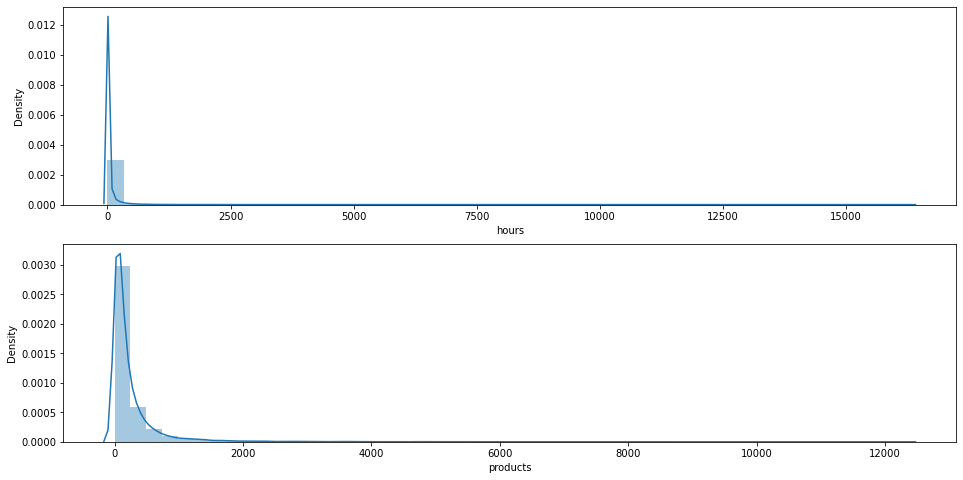

In [13]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

No es posible apreciar de manera adecuada una distribución de las variables debido a la gran cantidad de datos extremos que tiene en su cola derecha, por lo cual vamos a hacer una limpieza de esta cola con ayuda del rango intercuartílico

In [14]:
# Definimos las columnas sobre las cuales haremos la limpieza
cols_df_rev = ['hours', 'products']

# for a in range(len(cols_df_rev)):
#     # Determinamos el cuartil 25
#     Q1 = df_rev[cols_df_rev[a]].quantile(0.25)
#     # Determinamos el cuartil 75
#     Q3 = df_rev[cols_df_rev[a]].quantile(0.75)
#     # Determinamos el rango intercuartil
#     IQR = Q3 - Q1
#     # Filtramos los valores
#     filter = (df_rev[cols_df_rev[a]] <= Q3 + 3 * IQR)
#     df_rev = df_rev.loc[filter]

# # Muestra las dimensiones del nuevo dataset
# print(df_rev.shape)

C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


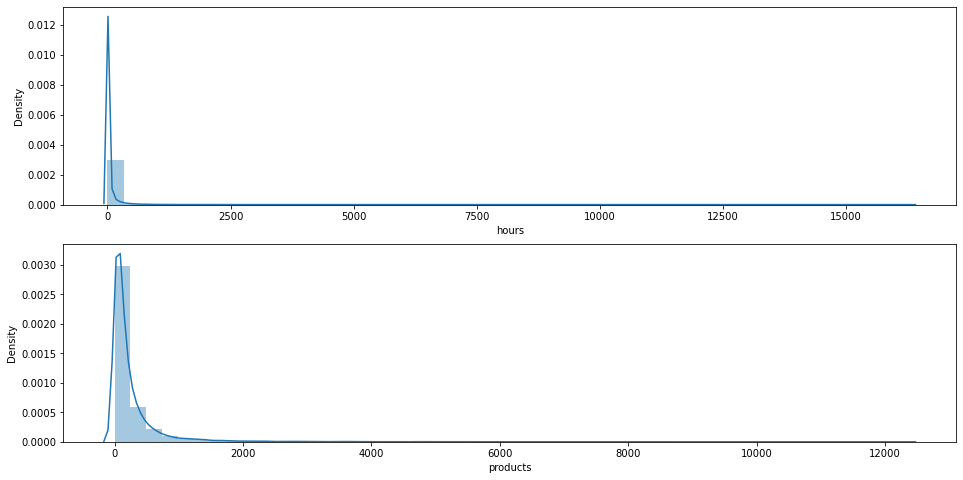

In [15]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

Aquí podemos observar claramente que tiene la forma de una ley de potencias, donde la mayor cantidad de datos se concentran en menor cantidad de productos y de horas jugadas.

In [16]:
df_rev.describe()

,hours,products
count,96785.000000,96794.000000
mean,55.055274,263.840486
std,239.067292,556.512043
min,0.000000,1.000000
25%,2.100000,39.000000
50%,9.000000,108.000000
75%,28.900000,266.000000
max,16341.200000,12309.000000


Ahora miraremos los datos faltantes de cada columna

In [17]:
from prettytable import PrettyTable

valNan = PrettyTable()

valNan.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_rev)):
    valNan1 = df_rev[cols_df_rev[a]].isna().sum()
    valNan.add_row([cols_df_rev[a],valNan1])

print(valNan)

+----------+---------------------+
| Columna  | # Valores faltantes |
+----------+---------------------+
|  hours   |         147         |
| products |         138         |
+----------+---------------------+


Para continuar con el análisis, haremos el mismo análisis para el dataset con la información de los juegos para luego relacionarlos

In [18]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Las columnas del dataset son:

* <b>publisher:</b> Contiene el nombre del editor 
* <b>genres:</b> Contiene información sobre los géneros que están asociados
* <b>app_name:</b> El nombre 
* <b>title:</b> El título
* <b>url:</b> Dirección web donde se encuentra
* <b>release_date:</b> Fecha de lanzamiento
* <b>tags:</b> Etiquetas colocadas para encontrar el juego
* <b>discount_price:</b> Precio con descuento
* <b>reviews_url:</b> Dirección web de las reseñas
* <b>specs:</b> Especificaciones del juego
* <b>price:</b> Precio full
* <b>early_access:</b> Si el juego tuvo "acceso anticipado" o no
* <b>id:</b> Código de identificación del juego
* <b>developer:</b> Contiene el nombre del desarrollador
* <b>sentiment:</b>
* <b>metascore:</b> 

Antes de eliminar las columnas que no son relevantes del dataset, vamos a ver los datos faltantes y así determinar qué columnas dejar o borrar, debido a que columnas como `"app_names"` y `"title"` parecen contener la misma información, al igual que `"publisher"` y `"developer"`

In [19]:
cols_df_games = list(df_games.columns)
valNan2 = PrettyTable()

valNan2.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_games)):
    valNan3 = df_games[cols_df_games[a]].isna().sum()
    valNan2.add_row([cols_df_games[a],valNan3])

print(valNan2)

+----------------+---------------------+
|    Columna     | # Valores faltantes |
+----------------+---------------------+
|   publisher    |         8052        |
|     genres     |         3283        |
|    app_name    |          2          |
|     title      |         2050        |
|      url       |          0          |
|  release_date  |         2067        |
|      tags      |         163         |
| discount_price |        31910        |
|  reviews_url   |          2          |
|     specs      |         670         |
|     price      |         1377        |
|  early_access  |          0          |
|       id       |          2          |
|   developer    |         3299        |
|   sentiment    |         7182        |
|   metascore    |        29458        |
+----------------+---------------------+


Eliminamos las columnas que no son relevantes para el fin de este proyecto

In [20]:
# Eliminamos las columnas que no son relevantes
df_games = df_games.drop(columns=['publisher', 'title', 'url', 'release_date', 'discount_price', 'reviews_url', 'specs',
                                  'price', 'early_access', 'sentiment', 'metascore', 'genres'])

In [21]:
# Eliminamos las instancias sin valor de 'id' y de 'app_name'

df_games = df_games.dropna(subset=['id', 'app_name'])

In [22]:
df_games

,app_name,tags,id,developer
0,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",761140,Kotoshiro
1,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",643980,Secret Level SRL
2,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",670290,Poolians.com
3,弹炸人2222,"[Action, Adventure, Casual]",767400,彼岸领域
4,Log Challenge,"[Action, Indie, Casual, Sports]",773570,NaN
...,...,...,...,...
32130,Colony On Mars,"[Strategy, Indie, Casual, Simulation]",773640,"Nikita ""Ghost_RUS"""
32131,LOGistICAL: South Africa,"[Strategy, Indie, Casual]",733530,Sacada
32132,Russian Roads,"[Indie, Simulation, Racing]",610660,Laush Dmitriy Sergeevich
32133,EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",658870,"xropi,stev3ns"


Ahora, vamos a juntar ambos datasets

In [23]:
df_games = df_games.rename(columns={"id": "product_id"})

In [24]:
df_steam = df_rev.merge(df_games, on="product_id")

In [25]:
## encodeamos el username para tener ids en numeros.
from sklearn.preprocessing import OrdinalEncoder
array = df_steam.username.astype(str)
oe = OrdinalEncoder()
users = oe.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)

df_steam.insert(0,'userid', users)

## borramos las ids viejas
df_steam.drop(columns=['user_id'], inplace=True)

In [26]:
df_steam

,userid,username,hours,products,product_id,app_name,tags,developer
0,9936,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
1,53680,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
2,74998,nd,1.0,2759.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
3,50261,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
4,81137,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
...,...,...,...,...,...,...,...,...
96927,3650,Andres Velasquez,50.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)"
96928,34536,Mauricio Perea,118.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)"
96929,3650,Andres Velasquez,100.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve
96930,3650,Andres Velasquez,100.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl


In [27]:
df_steam.isna().sum()

userid          0
username        0
hours         147
products      138
product_id      0
app_name        0
tags            0
developer      85
dtype: int64

In [28]:
df_steam_nd = df_steam[df_steam['developer'].isna() == True]['app_name'].value_counts()
df_steam_nd

Steam Dev Days                                   26
Streamer Simulator                               16
Hit & Run                                        13
In The Shadow                                    10
Creature Factory 2                                9
Gamer                                             3
Poco's Udon World                                 3
Robotpencil Presents: Improving Your Line Art     2
The Haunting in Connecticut                       1
After Dark Original: Area 51                      1
Galapagos Evolution                               1
Name: app_name, dtype: int64

Notamos que uno de los "juegos" al que le falta el valor de desarrollador se llama "Steam Dev Days", el cual es en realidad una conferencia que realiza la compañía y no un juego como tal, por lo tanto lo más recomendable sería hacer una categorización por géneros que no tengan etiquetas relacionadas a estos, tales como "documentary"

Siguiendo con el análisis, vamos a eliminar aquellas instancias con datos faltantes debido a que no son una porción representativa de nuestro total de datos

In [29]:
df_steam = df_steam.dropna()

In [30]:
df_steam.isna().sum()

userid        0
username      0
hours         0
products      0
product_id    0
app_name      0
tags          0
developer     0
dtype: int64

Ahora, teniendo el dataset entre usuarios y juegos relacionados, podemos responder varias preguntas, entre ellas:

* ¿Cuáles son los juegos más jugados?
* ¿Los usuarios que más productos tienen también son los que más horas jugadas tienen?
* Para los usuarios que más horas jugadas tienen ¿Qué juegos tienen en común?
* ¿Cuáles son los géneros de juegos que más se compran según el dataset?

### Los juegos con más horas jugadas

In [132]:
# Primero dejamos por fuera los datos ingresados en un inicio para probar el modelo
df_steam2 = df_steam[~((df_steam['userid']==3650) | (df_steam['userid']==34536))]

# Agrupamos el dataset por los juegos y sumamos los valores de las horas jugadas
df_top_games = df_steam2.groupby('app_name')['hours'].sum()
df_top_games

app_name
A Room Beyond                              41.3
A Timely Intervention                      58.1
A Valley Without Wind                    4696.6
Abscond                                     3.2
Action Henk                             13960.2
                                         ...   
[the Sequence]                            592.7
fault - milestone one                    7812.8
interLOGIC                                 46.3
rFactor                                 14480.0
東方天空璋 ～ Hidden Star in Four Seasons.     7694.3
Name: hours, Length: 313, dtype: float64

Nos parece importante tener en cuenta la cantidad de jugadores de cada juego, pues es un factor que influencia las métricas que se encontrarán

In [133]:
# Encontramos los valores únicos de los códigos de los usuarios, pues puede que hayan realizado más de un review 
df_steam_jugadores = df_steam2.groupby('app_name')['userid'].unique()

# Creamos una lista vacía que va a albergar la cantidad de jugadores
df_jugadores = []

# Contamos la cantidad de jugadores de cada juego y lo añadimos a la lista correspondiente
for a in range(df_steam_jugadores.size):
    df_jugadores.append(len(df_steam_jugadores[a]))

In [134]:
# Convertimos la variable Series a un DataFrame para así poder añadirle la cantidad de jugadores
df_top_games = df_top_games.to_frame()

In [135]:
# Añadimos la cantidad de jugadores al dataframe
df_top_games['players'] = df_jugadores
df_top_games

,hours,players
app_name,,
A Room Beyond,41.3,6
A Timely Intervention,58.1,6
A Valley Without Wind,4696.6,308
Abscond,3.2,3
Action Henk,13960.2,357
...,...,...
[the Sequence],592.7,70
fault - milestone one,7812.8,711
interLOGIC,46.3,19


In [137]:
# Obtenemos los 5 juegos con más horas jugadas en el dataset
df_top_games = df_top_games.sort_values(ascending = False, by = 'hours').head(5)

# Creamos la tabla para presentarlos
top_games_max = PrettyTable()

# Nombres de las columnas de las tablas
top_games_max.field_names = ['Juego', 'No. Horas jugadas', 'No. de jugadores']

for a in range(5):
    top_n1 = df_top_games.index[a]
    top_games_max.add_row([top_n1, round(df_top_games['hours'][a]), df_top_games['players'][a]])

print(top_games_max)

+--------------------+-------------------+------------------+
|       Juego        | No. Horas jugadas | No. de jugadores |
+--------------------+-------------------+------------------+
| Grand Theft Auto V |      1539558      |       7604       |
|     Brawlhalla     |       853672      |       6268       |
|   Time Clickers    |       475483      |       2251       |
| Heroes & Generals  |       314841      |       1902       |
|      Gnomoria      |       176571      |       1041       |
+--------------------+-------------------+------------------+


Habiendo hecho esto, nos surge la duda de si los juegos con más horas jugadas son los mismos con mayores horas jugadas en promedio, por lo que vamos a determinarlo

In [138]:
# Agrupamos el dataset por los juegos y hallamos el promedio de horas jugadas
df_top_games_mean = df_steam2.groupby('app_name')['hours'].mean()
df_top_games_mean

app_name
A Room Beyond                            6.883333
A Timely Intervention                    9.683333
A Valley Without Wind                   15.248701
Abscond                                  1.066667
Action Henk                             39.104202
                                          ...    
[the Sequence]                           8.467143
fault - milestone one                   10.942297
interLOGIC                               2.436842
rFactor                                 83.218391
東方天空璋 ～ Hidden Star in Four Seasons.    10.791445
Name: hours, Length: 313, dtype: float64

In [139]:
# Convertimos el objeto "Series" a "DataFrame" para poder agregar la cantidad de jugadores
df_top_games_mean = df_top_games_mean.to_frame()

In [140]:
# Agrego la columna de jugadores
df_top_games_mean['players'] = df_jugadores
df_top_games_mean

,hours,players
app_name,,
A Room Beyond,6.883333,6
A Timely Intervention,9.683333,6
A Valley Without Wind,15.248701,308
Abscond,1.066667,3
Action Henk,39.104202,357
...,...,...
[the Sequence],8.467143,70
fault - milestone one,10.942297,711
interLOGIC,2.436842,19


In [144]:
# Ordenamos el dataset según los juegos más jugados en promedio
df_top_games_mean = df_top_games_mean.sort_values(ascending=False, by='hours')

In [145]:
top_games_mean = PrettyTable()

top_games_mean.field_names = ['Juego', 'Promedio de horas jugadas', 'No. de jugadores']

for a in range(5):
    top_n1 = df_top_games_mean.index[a]
    top_games_mean.add_row([top_n1, round(df_top_games_mean['hours'][a]),df_top_games_mean['players'][a]])

print(top_games_mean)


+-------------------------------+---------------------------+------------------+
|             Juego             | Promedio de horas jugadas | No. de jugadores |
+-------------------------------+---------------------------+------------------+
|  Front Office Football Seven  |            857            |       115        |
| The Lord of the Rings Online™ |            344            |       276        |
| Illyriad - Grand Strategy MMO |            218            |        73        |
|         Time Clickers         |            211            |       2251       |
|       Grand Theft Auto V      |            201            |       7604       |
+-------------------------------+---------------------------+------------------+


Notamos que si bien hay coincidencias en juegos como "Grand Theft Auto V" y "Time Clickers", el promedio de estos está considerablemente por debajo de juegos como "Fron Office Football Seven", el cual tiene un promedio muy por encima del resto de juegos. Sin embargo, también notamos que este juego con el mayor promedio también tiene un cantidad de jugadores mucho menor que otros juegos como "Grand Theft Auto V"

Luego de haber notado lo anterior, nos surge una duda ¿Qué es más representativo frente a la calidad de un juego: Las horas jugadas en total o el promedio de las mismas?

## Correlación entre cantidad de productos y horas jugadas

In [159]:
df_products = df_steam2.groupby('username').sum().drop(columns=['userid'])
df_products

,hours,products
username,,
! DeadlyDeal !,2.5,406.0
! Taz the Husky,24.8,402.0
! cockle,188.5,56.0
!!!-One_shot=One_kill-!!!,1.6,10.0
!?,7.5,121.0
...,...,...
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡baphoyetz,17.3,39.0
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡,49.9,414.0
󠁿󠁿 󠁿󠁿 󠁿󠁿 󠁿,23.9,93.0


In [160]:
df_products.corr()

,hours,products
hours,1.00000,0.01124
products,0.01124,1.00000


Hallando una correlación entre ambas variables no da una buena correlación, pero también debemos tener en cuenta que el dataset tiene mucho ruido, entonces vamos a mirarlo manualmente con los 5 usuarios con más productos

In [165]:
df_products.sort_values(by='products', ascending=False).head(5)

,hours,products
username,,
Desolater IV,119.4,102108.0
rock3tz,45.2,50040.0
mark | dj.,45.4,49868.0
Salarn,34.7,48930.0
~=^[(O){d_b}(O)]^=~,69.9,48228.0


In [166]:
df_products.sort_values(by='hours', ascending=False).head(5)

,hours,products
username,,
Rydo,16341.2,861.0
dattebayo,16268.5,1188.0
roxxkatt,15045.1,236.0
form_an_opinion,14153.5,240.0
WurstPlay,12816.2,101.0


# MIRAR SI QUITANDO OUTLIERS DA MEJOR CORRELACIÓN##

### Géneros más jugados

In [276]:
df_steam21 = df_steam2.drop_duplicates(subset=['username','app_name'])

In [277]:
df_steam_tags = df_steam21.explode('tags')
tags = list(df_steam_tags['tags'])

In [273]:
df_steam_tags.groupby(['tags']).count().sort_values(by='hours', ascending=False)

,userid,username,hours,products,product_id,app_name,developer
tags,,,,,,,
Singleplayer,79444,79444,79444,79444,79444,79444,79444
Action,75397,75397,75397,75397,75397,75397,75397
Adventure,68490,68490,68490,68490,68490,68490,68490
Indie,58181,58181,58181,58181,58181,58181,58181
Atmospheric,49787,49787,49787,49787,49787,49787,49787
...,...,...,...,...,...,...,...
Trains,9,9,9,9,9,9,9
Swordplay,7,7,7,7,7,7,7
Sailing,4,4,4,4,4,4,4


In [278]:
df_steam_tags.groupby(['tags']).count().sort_values(by='hours', ascending=False)

,userid,username,hours,products,product_id,app_name,developer
tags,,,,,,,
Singleplayer,79082,79082,79082,79082,79082,79082,79082
Action,75035,75035,75035,75035,75035,75035,75035
Adventure,68141,68141,68141,68141,68141,68141,68141
Indie,57964,57964,57964,57964,57964,57964,57964
Atmospheric,49513,49513,49513,49513,49513,49513,49513
...,...,...,...,...,...,...,...
Trains,9,9,9,9,9,9,9
Swordplay,7,7,7,7,7,7,7
Sailing,4,4,4,4,4,4,4


In [245]:
from collections import Counter

In [259]:
dtags = Counter(tags)

In [268]:
tags_count = pd.DataFrame.from_dict(dtags, orient='index')
tags_count.sort_values(by=0, ascending=False).head(10)

,0
Singleplayer,79444
Action,75397
Adventure,68490
Indie,58181
Atmospheric,49787
Multiplayer,46787
Open World,35097
Great Soundtrack,34837
Casual,34615
Strategy,34477


### Juegos de las personas con mayor horas de juego

In [231]:
# Determinamos los 25 usuarios con mayor cantidad de horas jugadas
df_products2 = df_steam2.groupby('userid').sum()
top_players = list(df_products2.sort_values(by='hours', ascending=False).head(25).index)

In [232]:
# Agrupamos, por cada juego, los id's de los usuarios de dicho juego
games_players = df_steam2.groupby('app_name')['userid'].unique()
games_players

app_name
A Room Beyond                                   [6979, 29488, 69472, 48902, 41472, 53627]
A Timely Intervention                          [69768, 70772, 76165, 81498, 49273, 26587]
A Valley Without Wind                   [65651, 66110, 23102, 63211, 77934, 67307, 304...
Abscond                                                             [43689, 18868, 61652]
Action Henk                             [61615, 64965, 63871, 52646, 14615, 14035, 351...
                                                              ...                        
[the Sequence]                          [61884, 72050, 66838, 43195, 65745, 65673, 759...
fault - milestone one                   [41737, 23303, 454, 31369, 33030, 13217, 80895...
interLOGIC                              [72207, 37553, 76015, 29712, 7598, 79097, 6153...
rFactor                                 [62481, 22780, 52662, 19058, 54037, 23589, 647...
東方天空璋 ～ Hidden Star in Four Seasons.    [24047, 84798, 48511, 37153, 71922, 42974, 128...
N

In [233]:
# Creo una lista para almacenar los juegos que se repiten
games = []

# Ciclo para determinar si los jugadores se encuentran dentro de la lista de cada juego
for a in range (len(games_players)):
    if any(x in top_players for x in games_players[a]):
        games.append(games_players.index[a])
    else:
        pass

In [236]:
games_repeat = PrettyTable()

games_repeat.field_names = ['Juego']

for a in range(len(games)):
    games_repeat.add_row([games[a]])

print(games_repeat)

+-------------------------------+
|             Juego             |
+-------------------------------+
|           Brawlhalla          |
|          Crush Crush          |
|  Front Office Football Seven  |
|            Gnomoria           |
|       Grand Theft Auto V      |
|       Heroes & Generals       |
|        Source Filmmaker       |
|           Spellstone          |
| The Lord of the Rings Online™ |
|         Time Clickers         |
|        Who's Your Daddy       |
+-------------------------------+


Como era de esperarse, muchos de los juegos aquí encontrados son también los que se encuentran junto con horas más jugadas

## ¿Cuáles son los géneros de juegos que más se compran?

# ---

In [41]:
df_steam2 = df_steam.merge(df_mean, on='app_name')
df_steam2

,userid,username,hours,products,product_id,app_name,tags,developer,mean_hours
0,9936,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5
1,53680,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5
2,74998,nd,1.0,2759.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5
3,50261,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5
4,81137,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5
...,...,...,...,...,...,...,...,...,...
96566,3650,Andres Velasquez,50.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0
96567,34536,Mauricio Perea,118.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0
96568,3650,Andres Velasquez,100.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve,100.0
96569,3650,Andres Velasquez,100.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl,100.0


In [42]:
df_steam2['hours_percent'] = ((df_steam2.hours) * 100) / df_steam2.mean_hours
df_steam = df_steam2.copy()
df_steam

,userid,username,hours,products,product_id,app_name,tags,developer,mean_hours,hours_percent
0,9936,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,20.00000
1,53680,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,180.00000
2,74998,nd,1.0,2759.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,200.00000
3,50261,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,120.00000
4,81137,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,60.00000
...,...,...,...,...,...,...,...,...,...,...
96566,3650,Andres Velasquez,50.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0,59.52381
96567,34536,Mauricio Perea,118.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0,140.47619
96568,3650,Andres Velasquez,100.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve,100.0,100.00000
96569,3650,Andres Velasquez,100.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl,100.0,100.00000


# Preprocesamiento de datos


In [40]:
df_mean.drop(columns=['userid', 'products'], inplace=True)
df_mean = df_mean.rename(columns={'hours':'mean_hours'})
df_mean

,mean_hours
app_name,
A Room Beyond,6.883333
A Timely Intervention,9.683333
A Valley Without Wind,15.248701
Abscond,1.066667
Action Henk,39.104202
...,...
[the Sequence],8.467143
fault - milestone one,10.942297
interLOGIC,2.436842


In [43]:
## eliminamos a las reviews que tengan 0 horas jugadas, pues no da una buena señal de
## la confiabilidad de su review, por que son pocos, y por que
## limita el encoding que queremos hacer
print(df_steam[~(df_steam['hours']==0)].size - df_steam.size)
df_steam = df_steam[~(df_steam['hours']==0)]

-600


(0.0, 100.0)

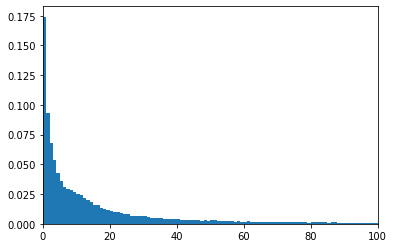

In [44]:
## Vemos la distribucion actual de los datos
df_steam.hours
plt.hist(x=df_steam.hours, bins=100, density=True, range=(0,100))
plt.xlim([0,100])

In [45]:
## lo que tenemos aqui es una distribucion
## de 'power law' o 'right skewed' que vamos a encodear
## primero sacandole su logaritmo para hacerla mas parecida
## a una distribucion gausiana y despues la encodeamos con las
## herramientas de sklearn.

df_steam['log_hours'] = np.log(df_steam.hours_percent)

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(-5.0, 10.0)

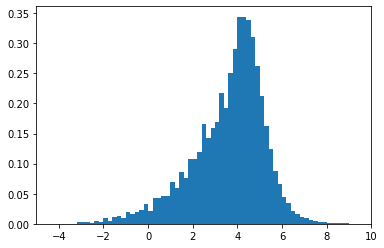

In [46]:
## escalado logaritmico
plt.hist(x=df_steam.log_hours, bins=100, density=True, range=(-10,10))
plt.xlim([-5,10])

In [47]:
# Encoding sklearn. De 1 a 10 para que queden como si fuera
# una review y que Surprise pueda leerlas correctamente

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_steam.log_hours).reshape(-1, 1))
df_steam['escalados'] = dataset

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


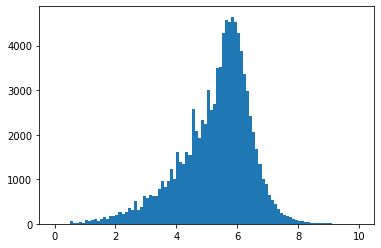

In [48]:
# resultado final de los datos
plt.hist(x=df_steam.escalados, bins=100)
plt.show()

In [49]:
df_steam

,userid,username,hours,products,product_id,app_name,tags,developer,mean_hours,hours_percent,log_hours,escalados
0,9936,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,20.00000,2.995732,4.853777
1,53680,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,180.00000,5.192957,6.433020
2,74998,nd,1.0,2759.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,200.00000,5.298317,6.508747
3,50261,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,120.00000,4.787492,6.141594
4,81137,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.5,60.00000,4.094345,5.643399
...,...,...,...,...,...,...,...,...,...,...,...,...
96566,3650,Andres Velasquez,50.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0,59.52381,4.086376,5.637672
96567,34536,Mauricio Perea,118.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",84.0,140.47619,4.945038,6.254830
96568,3650,Andres Velasquez,100.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve,100.0,100.00000,4.605170,6.010552
96569,3650,Andres Velasquez,100.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl,100.0,100.00000,4.605170,6.010552


# Modelo de sistema de recomendacion

In [50]:
#### Preparacion del dataset objeto de Surprise
### Orden de las features
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_steam[['userid', 'product_id', 'escalados']] #date lacking
## crear una copia del dataset por seguridad
df_reader_og = df_steam[['userid', 'product_id', 'escalados', 'username']]
df_reader

,userid,product_id,escalados
0,9936,725280,4.853777
1,53680,725280,6.433020
2,74998,725280,6.508747
3,50261,725280,6.141594
4,81137,725280,5.643399
...,...,...,...
96566,3650,8930,5.637672
96567,34536,8930,6.254830
96568,3650,620,6.010552
96569,3650,113200,6.010552


In [51]:
## Creacion objeto reader y el dataset 
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [52]:
## Separar sets de entrenamiento y testeo
trainset, testset = train_test_split(data, test_size=.25)

# Eleccion y optimizacion del modelo

In [78]:
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

benchmark = []
algorits = [SlopeOne(), BaselineOnly(), SVDpp(), SVD(), NormalPredictor()] # KNNWithMeans(), BaselineOnly() #SVDpp(), SlopeOne(), NMF()
# Iterate over all algorithms
for algorithm in algorits:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.091656,0.428984,0.289173
SVD,1.096423,4.688126,0.221897
SVDpp,1.119571,7.260201,0.317233
SlopeOne,1.216650,0.994771,0.285901
NormalPredictor,1.656893,0.123754,0.319253


In [80]:
## optimizacion con gridsearch svd
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
gs.best_score['rmse'], gs.best_params, gs.best_estimator

In [ ]:
### Testear el algoritmo optimizado en el dataset
algo = gs.best_estimator['rmse']
resultados = pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
#resultados

In [54]:
## funcion para traducir los resultados de la funcion 'predecir()'
def traducir(preds):
    rows_list = []
    ## coger el username por medio de los indices
    for user in preds:
        index_user = df_reader.loc[df_reader.userid == user].index[0]
        username = df_reader_og[df_reader_og.index == index_user].username.values[0]
    ## coger el titulo del juego y el rating
        revs = preds[user]
        for game_id, score in revs:
            game_name = df_games.loc[df_games.product_id == game_id].app_name.values[0]
            ## transformar el score a horas
            hours = np.exp(score)
            ## anadirlo al data frame
            dict = {
                'usename':username,
                'game_id':game_name,
                'expected_hours':hours
            }
            rows_list.append(dict)
    df = pd.DataFrame(rows_list)
    return df

In [55]:
### definir funcion para que prediga un numero de peliculas al azar
### con el dataset

def predecir(dataset,
            algo,
            n_random_games=15,
            n_random_users=50,
            top=5,
            game_ids=0,
            user_ids=0,
            predicts=10):
    '''
    Esta funcion crea un diccionario con predicciones que los usuarios no han 
        rateado.
    - num_predicts: es el numero de predicciones que hacer para cada usuario
    - user_ids: el id de las personas, si rand_users es True, no hay que poner            user_ids.
    - rand_users: si coger a usuers al azar para hacer predicciones.
    - dataset: el dataset con las predicciones con las que se entrena el modelo. en       nuestro caso "df_reader".
    - algo: el algoritmo que se va a use. En nuesto caso "algo2".
    '''
    predicted = defaultdict(list)
    ## if the input is empty or 0 get random get random items
    total_games = len(dataset.product_id.value_counts().index)
    total_users = len(dataset.userid.value_counts().index)
    if game_ids==0:
        if n_random_games > total_games:
            n_random_games = total_games
        j = dataset.product_id.value_counts().index
        game_ids=random.sample(list(j), n_random_games)
    if user_ids==0:
        if n_random_users > total_users:
            n_random_users = total_users
        u = dataset.userid.value_counts().index
        user_ids = random.sample(list(u), n_random_users)

    ### loop trough users and games and append to 'predicted'
    for user in user_ids:
        for game in game_ids:
            ## skipear si ya habia rateado el juego
            v = dataset.loc[(dataset.userid == user) & (dataset.product_id == game)]
            if len(v) == 0:
                ## predict and append the predictions
                pred = algo.predict(user, game)
                predicted[pred[0]].append((pred[1],pred[3]))

    # sort the predictions for each user
    for uid, user_ratings in predicted.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        predicted[uid] = user_ratings[:top]
    return traducir(predicted)



In [56]:
## probar la funcion y coger un pequeno dataset ara traducir
predecir(df_reader, algo, n_random_games=30000, user_ids=[34536, 3650])

,usename,game_id,expected_hours
0,Mauricio Perea,Unhack,470.422756
1,Mauricio Perea,Ghost of a Tale,462.045177
2,Mauricio Perea,Grim Legends 3: The Dark City,441.888743
3,Mauricio Perea,The Dark Stone from Mebara,430.500153
4,Mauricio Perea,Snakebird,423.949722
5,Andres Velasquez,Super Killer Hornet: Resurrection,455.207122
6,Andres Velasquez,The Dark Stone from Mebara,416.807419
7,Andres Velasquez,Ziggurat,412.438213
8,Andres Velasquez,Riaaf The Spider,408.510334
9,Andres Velasquez,Wooden Sen'SeY,402.450685


In [57]:
### tag en particular